# Modeling *E. coli* growth

In [1]:
import cobra.test
import cobra
from matplotlib import pyplot as plt
import escher
from qbio_resources.phase_plane import calculate_phenotype_phase_plane
from qbio_resources.plotting_functions import visualize_flux

/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## A) Modeling growth on varying electron acceptors

The use of the electron transport chain (ETC) and oxidative respiration enables highly efficient ATP generation in *E. coli*. An essential component of the ETC, however, is the presence of an electronegative electron acceptor as the strong attraction between electrons and the acceptor essentially powers the process.

Oxygen is the most ubiquitous bacterial electron acceptor and therefore bacterial are often only considered as growing either aerobically or anaerobically. However, E. coli has evolved to various other chemicals as electron acceptors in the absence of oxygen. Some of these include:

- Nitrate (NO3)
- Nitrite (NO2)
- Dimethylsulfoxide (DMSO)
- Trimethylamine N-oxide (TMAO)

This section will assess the efficacy of some of these additional electron acceptors to produce ATP

### 1) Load the model as a variable called `model`
 - Since the cellular ATP requirements should be considered in totality, the lower bound of the non-growth dependent ATP maintenance reaction (ATPM) should not be set to 0

In [2]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')

### 2) Begin by optimizing the model using `pfba()` in default aerobic conditions 
- Save the solution in a variable called `solution`

In [3]:
solution = cobra.flux_analysis.pfba(model)

### 3) Observe the flux balance of periplasm hydrogen (h_p) using the `metabolite.summary()` function
 - This function provides all the reaction creating and consuming h_p
 - The gradient of hydrogen across the inner membrane (i.e., a build of hydrogen in periplasmic space) ultimately powers ATP synthesis via the ATP synthase (ATPS4rpp) reaction
 - The sum of fluxes producing h_p will be proportional to the amount of ATP the cell can synthesize

In [4]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
61%  177     CYTBO3_4pp  4.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 4.0 h_p...
39%  114     NADH16pp    4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
97%  282     ATPS4rpp    adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
3%     8.06  Htex        h_e <=> h_p


### 4) Observe the flux balance of NAD+ (nad_c) using the `metabolite.summary()` function
 - Reduced NADH donates the electrons that enter ETC and provide the energy to translocate h+ accross the inner membrane
 - NAD must be available within the cell in order for glycolysis. If the cell does not have a way to oxidize NADH to NAD via the ETC, then it likely must look for other methods of doing so.

In [5]:
model.metabolites.nad_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
95%  38      NADH16pp  4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...
5%    1.92   FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
43%  17.1    GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
24%   9.69   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
17%   6.88   MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
15%   5.97   AKGDH     akg_c + coa_c + nad_c --> co2_c + nadh_c + succ...
4%    1.51   PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c
1%    0.395  IPMD      3c2hmp_c + nad_c --

### 5) Calculate the efficiency of the electron acceptor to produce ATP
 - This will be the ratio of ATP synthesis flux powered by H+ and the flux of electron acceptor reduction

**Hint:** it's a reasonable assumption that the electron acceptor will be reduced at the rate it is taken up

In [6]:
print('Efficiency =', model.reactions.ATPS4rpp.flux / abs(model.reactions.EX_o2_e.flux))

Efficiency = 3.1824167329954554


### 6) Use `model.summary()` to receive an output of the metabolite uptake and secretion fluxes 
- Note the secretion products (out fluxes). 
- The solution can also be observed over a flux map using `visualize_flux(reaction_fluxes)` like in Exercise 1

In [7]:
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ----------------------
o2_e      22.1       h2o_e  47.2   BIOMASS_Ec_i...  0.877
glc__D_e  10         co2_e  24
nh4_e      9.47      h_e     8.06
pi_e       0.846
so4_e      0.221
k_e        0.171
fe2_e      0.0141
mg2_e      0.00761
ca2_e      0.00456
cl_e       0.00456
cu2_e      0.000622
mn2_e      0.000606
zn2_e      0.000299
ni2_e      0.000283


In [8]:
visualize_flux(solution.fluxes)

### 7) Repeate 1-6 with $\mathrm{NO_3}$ (no3) as the electron acceptor instead of oxygen

 - Allow unlimited (-1000 $\frac{mmol}{gDW \cdot hr}$) uptake of no3_e
 - Note the stoichiometry of the reactions capable of translocating H+ into the periplasm
   - NO3 is less electronegative and thus can power less translocation of H+ against the electrochemical gradient
   
 - **Don't forget to the set oxygen uptake to 0 and reset the uptake of the no3 to 0 after this analysis!**
 

In [13]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.reactions.EX_o2_e.lower_bound = 0
model.reactions.EX_no3_e.lower_bound = -1000
solution = cobra.flux_analysis.pfba(model)

In [10]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
56%  134     NADH16pp  4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...
44%  106     NO3R1pp   2.0 h_c + no3_c + q8h2_c --> h2o_c + 2.0 h_p + ...

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
97%  231     ATPS4rpp  adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
3%     7.15  Htex      h_e <=> h_p


In [43]:
model.metabolites.nad_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
97%   51     NADH16pp  4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...
3%     1.5   FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
35%   18.4   GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
24%   12.6   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
20%   10.4   MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
18%    9.67  AKGDH     akg_c + coa_c + nad_c --> co2_c + nadh_c + succ...
3%     1.33  NADTRHD   nad_c + nadph_c --> nadh_c + nadp_c
2%     1.18  PGCD      3pg_c + nad_c --> 3php_

In [14]:
print('Efficiency =', model.reactions.ATPS4rpp.flux / abs(model.reactions.EX_no3_e.flux))

Efficiency = 1.093602042457895


In [15]:
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ----------------------
no3_e     52.8       no2_e  52.8   BIOMASS_Ec_i...  0.778
glc__D_e  10         h2o_e  48.6
nh4_e      8.4       co2_e  28.1
pi_e       0.75      h_e     7.15
so4_e      0.196
k_e        0.152
mg2_e      0.00675
fe2_e      0.00642
fe3_e      0.00607
ca2_e      0.00405
cl_e       0.00405
cu2_e      0.000551
mn2_e      0.000537
zn2_e      0.000265
ni2_e      0.000251


In [16]:
visualize_flux(solution.fluxes)

### 8) Repeate 1-6 with Dimethylsulfoxide (dmso_e) as the electron acceptor instead of oxygen
 - Allow unlimited (-1000 $\frac{mmol}{gDW \cdot hr}$) uptake of dmso_e
 - Note the number of reactions capable of translocating H+ into the periplasm and the stoichiometry of those reactions
   - DMSO is even less electronegative then no3 and thus can power less translocation of H+ against the electrochemical gradient
 - Also note the byproduct secretion. Performing the `metabolite.summary()` command for atp_c will give clues to why this is happening
  - **Don't forget to the set oxygen uptake to 0 and reset the uptake of the dmso to 0 after this analysis!**

In [17]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.reactions.EX_o2_e.lower_bound = 0
model.reactions.EX_dmso_e.lower_bound = -1000
solution = cobra.flux_analysis.pfba(model)

In [18]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
99%  194     NADH18pp  2dmmq8_c + 4.0 h_c + nadh_c --> 2dmmql8_c + 3.0...
1%     2.63  ACt2rpp   ac_p + h_p <=> ac_c + h_c

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
94%  185     ATPS4rpp  adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
4%     7.39  Htex      h_e <=> h_p
2%     3.65  GLCt2pp   glc__D_p + h_p --> glc__D_c + h_c


In [19]:
model.metabolites.nad_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
98%   64.6   NADH18pp  2dmmq8_c + 4.0 h_c + nadh_c --> 2dmmql8_c + 3.0...
2%     1.13  FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
78%   51     NADTRHD   nad_c + nadph_c --> nadh_c + nadp_c
14%    9.2   GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
7%     4.83  PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
1%     0.89  PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c


In [21]:
print('Efficiency =', model.reactions.ATPS4rpp.flux / abs(model.reactions.EX_dmso_e.flux))

Efficiency = 0.7127453934278751


In [20]:
model.summary()

IN FLUXES            OUT FLUXES         OBJECTIVES
-------------------  -----------------  ----------------------
dmso_e    64.8       dms_e   64.8       BIOMASS_Ec_i...  0.518
glc__D_e  10         h2o_e   47.2
nh4_e      5.59      co2_e   33.5
pi_e       0.499     h_e      7.39
so4_e      0.13      ac_e     2.63
k_e        0.101     succ_e   0.000296
mg2_e      0.00449
fe2_e      0.00427
fe3_e      0.00404
cl_e       0.00269
ca2_e      0.00269
cu2_e      0.000367
mn2_e      0.000358
zn2_e      0.000176
ni2_e      0.000167


In [22]:
visualize_flux(solution.fluxes)

In [24]:
# A small percent of ATP now comes from acetate production
model.metabolites.atp_c.summary()

PRODUCING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
80%  46.2    ATPS4rpp    adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
16%   9.2    PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
4%    2.33   ACKr        ac_c + atp_c <=> actp_c + adp_c

CONSUMING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
68%  39.1    BIOMASS...  0.000223 10fthf_c + 2.6e-05 2fe2s_c + 0.000223 ...
12%   6.86   ATPM        atp_c + h2o_c --> adp_c + h_c + pi_c
6%    3.65   HEX1        atp_c + glc__D_c --> adp_c + g6p_c + h_c
3%    1.77   NDPK1       atp_c + gdp_c <=> adp_c + gtp_c
1%    0.811  GLNS        atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c +...
1%    0.553  ASPK        asp__L_c + atp_c <=> 4pasp_c 

### 9) Repeate 1-6 with no electron acceptors (anaerobic growth)
 - Do not calculate the efficiency because this will obviously be zero
 - The model predicts secretion of 4 carbon containing metabolites
  - Using the mass balances summaries of nad_c and atp_c and the displayed flux map, can you predict why these metabolites are secreted during anaerobic growth (fermentation)

In [27]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.reactions.EX_glc__D_e.lower_bound = -10
model.reactions.EX_o2_e.lower_bound = 0
solution = cobra.flux_analysis.pfba(model)

In [26]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
73%   23.9   ATPS4rpp  adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
27%    8.83  ACt2rpp   ac_p + h_p <=> ac_c + h_c

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
88%   28.6   Htex      h_e <=> h_p
12%    3.85  THD2pp    2.0 h_p + nadh_c + nadp_c --> 2.0 h_c + nad_c +...


In [33]:
model.metabolites.nadh_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
99%  19.6    GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
1%    0.262  PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
44%   8.75   ACALD     acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
44%   8.75   ALCD2x    etoh_c + nad_c <=> acald_c + h_c + nadh_c
10%   1.93   THD2pp    2.0 h_p + nadh_c + nadp_c --> 2.0 h_c + nad_c +...
2%    0.344  FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c


In [30]:
model.summary()

IN FLUXES            OUT FLUXES       OBJECTIVES
-------------------  ---------------  ----------------------
glc__D_e  10         h_e     28.6     BIOMASS_Ec_i...  0.158
h2o_e      4.59      for_e   18.2
nh4_e      1.7       ac_e     8.83
pi_e       0.152     etoh_e   8.75
co2_e      0.0578    succ_e   0.0526
so4_e      0.0397
k_e        0.0308
mg2_e      0.00137
fe2_e      0.0013
fe3_e      0.00123
ca2_e      0.00082
cl_e       0.00082
cu2_e      0.000112
mn2_e      0.000109
zn2_e      5.37e-05
ni2_e      5.09e-05


In [32]:
visualize_flux(solution.fluxes)

## B) Modeling growth regions
The above analysis modeled E. coli growth in discrete states (i.e., aerobic in oxygen excess or anaerobic with no oxygen present). 

This section will highlight and characterize some of the interesting model behavior that occurs between these two extremes. We'll start by creating a phenotypic phase plane that shows the full range of behavior that occurs as the **in silico** substrates are varied.

### 1) Load a new model as a variable called `model`

In [2]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')

In [4]:
data = calculate_phenotype_phase_plane(model, reaction1_name='EX_glc__D_e', reaction2_name='EX_o2_e', reaction1_npoints=10, reaction2_npoints=10)

/Users/coltonlloyd/Envs/qbio18/lib/python3.6/site-packages/matplotlib/figure.py:2267 UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


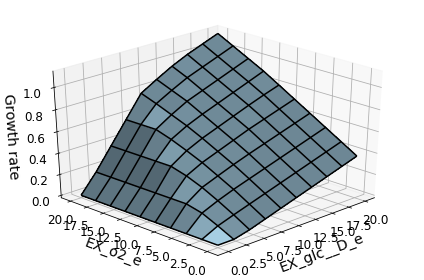

In [5]:
data.plot()

In [47]:
import mpl_toolkits

In [49]:
model.slim_optimize?

In [ ]:
ax.

In [14]:
model.optimize()

[(i.id, i.x) for i in model.genes.b3177.reactions]

[('DHPS2', 0.0005867111364514788)]

In [16]:
model = cobra.io.load_json_model('../qbio_resources/model1515.json')
model.reactions.BIOMASS_Ec_model1515_core_75p37M.lower_bound = model.optimize().f
model.objective = 'DHPS2'
print(model.optimize())
print(model.optimize('minimize'))

<Solution 0.001 at 0x119e499b0>
<Solution 0.001 at 0x119e495c0>


In [17]:
import numpy
bounds = numpy.linspace(0, 80)
grs = []
for i in bounds:
    model.reactions.EX_o2_e.lower_bound = -20
    model.reactions.a.lower_bound = i
    grs.append(model.slim_optimize())

AttributeError: DictList has no attribute or entry a

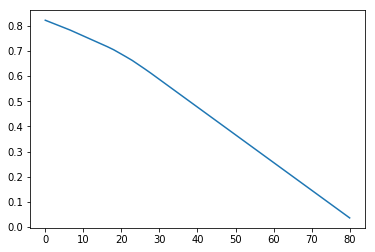

In [104]:
from matplotlib import pyplot as plt
plt.plot(bounds, grs)
plt.show()

In [72]:
model.objective.expression

-1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685 + 1.0*BIOMASS_Ec_iML1515_core_75p37M

In [110]:
model = cobra.io.load_json_model('../qbio_resources/model1515.json')

In [98]:
r = cobra.Reaction('a')
model.add_reaction(r)
r.add_metabolites({'10fthf_c': -1, 'thf_c': 1})
#model.add_boundary(model.metabolites.get_by_id('thf_c'), reaction_id='DM_thf_c',lb=0)

In [75]:
model.reactions.BIOMASS_Ec_model1515_core_75p37M.add_metabolites({'10fthf_c': 0, 'thf_c': 0, 'mlthf_c': 0}, combine=False  )

In [77]:
model.metabolites.thf_c.reactions

frozenset({<Reaction AICART at 0x7f962f8f1978>,
           <Reaction BIOMASS_Ec_iML1515_WT_75p37M at 0x7f962f19a908>,
           <Reaction DHFR at 0x7f962f98b6a0>,
           <Reaction FTHFD at 0x7f962fd8a710>,
           <Reaction FTHFLi at 0x7f962fcc7160>,
           <Reaction GARFT at 0x7f962fd300b8>,
           <Reaction GHMT2r at 0x7f962fd95c18>,
           <Reaction GLYCL at 0x7f962fda22e8>,
           <Reaction METS at 0x7f962fc596a0>,
           <Reaction MOHMT at 0x7f962fcc29e8>,
           <Reaction ULA4NFT at 0x7f962f8b5940>})

In [76]:
model.optimize()

,fluxes,reduced_costs
ALATA_D2,0.000000,-7.525116e-03
SHCHD2,0.000196,0.000000e+00
CPPPGO,0.000196,0.000000e+00
GTHOr,0.217092,0.000000e+00
DHORD5,0.003425,2.775558e-17
...,...,...
SUCCt1pp,0.000000,0.000000e+00
QUINDH,0.000000,-1.881279e-03
LCARSyi,0.000000,-1.881279e-03
BIOMASS_Ec_iML1515_core_75p37M,0.877203,-6.335739e-16


## C) Modeling antibiotic interventions

 1. Impose knock outs of genes/reactionts affected by each of these antibiotics
 2. Find which biomass constituents are "blocked" by knockout 
  - Optimize for production of each metabolite in the biomass objective function to determine growth deficiency
    1. Loop through metabolites in biomass objective function

## C) Modeling microbiotic mechanisms
**Goal:** 

Use metabolic models to understand how common antibiotics (ampicillin, sulfonamides) act to kill bacteria

**Mechanisms of action:**
 1. Amoxicillin is a beta-lactam antibiotic with a mechanism of action that irreversibly inhibits transpeptidases (b0084, ftsI)

 2. Sulfonamides competitively inhibit dihydropteroate synthase (b3177, folP)

**Approach:**
    
1. Get the reaction(s) catalyzed by each inhibited gene
2. Optimize the model on glucose minimal media to get the "wild-type" flux through the reaction at the maximum growth rate
2. Titrate the "concentration" of the antiobiotic by observing the reduction in activity of the inhibited reaction(s) from wild-type down to zero.


In [29]:
def determine_blocked_biomass(model):
    for met in model.reactions.BIOMASS_Ec_model1515_core_75p37M.metabolites:
        r = cobra.Reaction('DM_%s' % met.id)
        model.add_reaction(r)
        r.add_metabolites({met: -1})
        model.objective = r
        sol = model.optimize()
        if abs(sol.f ) < .1:
            print('\tMetabolite (%s, %s) is blocked' % (met.id, met.name))

In [30]:
for gene in ['b0084', 'b3177']:
    model = model.copy()
    model.genes.get_by_id(gene).remove_from_model()
    print('When gene %s is removed the growth rate is %.2f' % (gene, model.optimize().f))
    determine_blocked_biomass(model)
    print('')

cobra/core/gene.py:236 UserWarning: Use cobra.manipulation.remove_genes instead


When gene b0084 is removed the growth rate is 0.00
	Metabolite (murein5px4p_p, Two disacharide linked murein units, pentapeptide crosslinked tetrapeptide (A2pm->D-ala) (middle of chain)) is blocked

When gene b3177 is removed the growth rate is -0.00
	Metabolite (10fthf_c, 10-Formyltetrahydrofolate) is blocked
	Metabolite (mlthf_c, 5,10-Methylenetetrahydrofolate) is blocked
	Metabolite (thf_c, 5,6,7,8-Tetrahydrofolate) is blocked



**Amoxicillin disrupts cell wall synthesis**
 - Murein is an essential part of cell wall formation
 
**Sulfonamides disrupt folate metabolism**
 - Tetrahydrofolates (vitamin B9) are essential for donating one carbon units (hydroxymethyl/formyl groups) during metabolite biosynthesis

In [77]:
model = cobra.io.load_json_model('../qbio_resources/model1515.json')
bounds = numpy.linspace(0, 5, 40)
ys = []
model.reactions.EX_glc__D_e.lower_bound = -20
for l in bounds:
    model.reactions.EX_nh4_e.lower_bound = -l
    ys.append(model.slim_optimize(error_value=0))

In [79]:
model.medium

{'EX_pi_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 20,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_nh4_e': 5.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

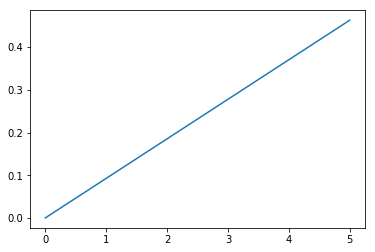

In [78]:
plt.plot(bounds, ys)

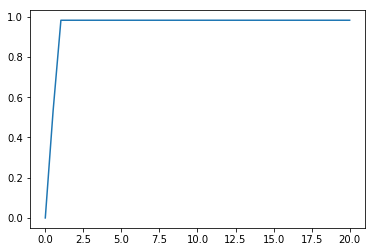

In [58]:
plt.plot(bounds, ys)

In [47]:
model.reactions.EX_glc__D_e.lower_bound = -5
cobra.flux_analysis.pfba(model
                        )
model.summary()

IN FLUXES           OUT FLUXES    OBJECTIVES
------------------  ------------  ----------------------
o2_e      9.07      h2o_e  22.9   Ec_biomass_i...  0.485
nh4_e     5.23      co2_e  10.1
glc__D_e  5         h_e     4.45
pi_e      0.468
so4_e     0.122
k_e       0.0946
fe2_e     0.00778
mg2_e     0.0042
ca2_e     0.00252
cl_e      0.00252
cu2_e     0.000344
mn2_e     0.000335
zn2_e     0.000165
ni2_e     0.000157
mobd_e    6.25e-05


In [49]:
model.reactions.EX_glc__D_e.lower_bound = -12
cobra.flux_analysis.pfba(model)
model.summary()

IN FLUXES            OUT FLUXES       OBJECTIVES
-------------------  ---------------  ---------------------
o2_e      20         h2o_e  52.8      Ec_biomass_i...  1.15
nh4_e     12.4       co2_e  22.5
glc__D_e  12         h_e    11.7
pi_e       1.11      ac_e    1.17
so4_e      0.29      for_e   0.00282
k_e        0.224
mg2_e      0.00997
fe2_e      0.00949
fe3_e      0.00898
ca2_e      0.00598
cl_e       0.00598
cu2_e      0.000815
mn2_e      0.000795
zn2_e      0.000392
ni2_e      0.000371
mobd_e     0.000148


In [52]:
model.reactions.EX_glc__D_e.lower_bound = -20
cobra.flux_analysis.pfba(model)
model.summary()

AttributeError: DictList has no attribute or entry EX_glc__D_e

In [57]:
model = cobra.test.create_test_model('ecoli')
bounds = numpy.linspace(0, 20, 40)
ys = []
model.reactions.EX_o2_e.lower_bound = -100
model.reactions.EX_glc_e.lower_bound = -10
for l in bounds:
    model.reactions.EX_pi_e.lower_bound = -l
    ys.append(model.slim_optimize(error_value=0))